In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

import time
start_time = time.time()

# Experiment Config

In [2]:
EXP_CONFIG_UQ=0.99
EXP_CONFIG_UC=0.99
EXP_CONFIG_OUTER_FOLDS=10
EXP_CONFIG_INNER_FOLDS=3
EXP_CONFIG_HYPER_PARAM_CONFIGS=10
EXP_CONFIG_SAMPLE_COMPLEXITY_FOLDS=10
EXP_CONFIG_FEATURE_IMPORTANCE_FOLDS=5

# Pre-Processing

## Generate graph metadata and data frames

In [3]:
# Runs 2h+ on MBP
# from src.data_loader import generate_graph_dfs_and_metadata
# generate_graph_dfs_and_metadata()

100%|██████████████████████████████████████████████████████████| 2662/2662 [1:58:19<00:00,  2.67s/it]


## Create training data from scratch

In [4]:
from src.data_loader import (get_graph_metadata, create_training_data)

# Runs 24min+ on MBP
# graph_metadata = get_graph_metadata(filter_nas=True)
# create_training_data(graph_metadata, from_file=False)

100%|████████████████████████████████████████████████████████████| 1966/1966 [22:37<00:00,  1.45it/s]


,did_break,global_pre_absolute_auto_no_of_edges_of_type_create_node,global_pre_absolute_auto_no_of_edges_of_type_insert_node,global_pre_absolute_auto_no_of_edges_of_type_structure,global_pre_absolute_auto_no_of_edges_of_type_set_attribute,global_pre_absolute_auto_no_of_edges_of_type_remove_node,global_pre_absolute_auto_no_of_edges_of_type_add_event_listener,global_pre_absolute_auto_no_of_edges_of_type_event_listener,global_pre_absolute_auto_no_of_edges_of_type_js_result,global_pre_absolute_auto_no_of_edges_of_type_js_call,...,global_pre_absolute_auto_no_of_edges_of_type_clear_storage,global_relative_auto_no_of_edges_of_type_clear_storage,local_pre_absolute_auto_no_of_source_nodes_of_type_session_storage,local_relative_auto_no_of_source_nodes_of_type_session_storage,local_delta_absolute_auto_no_of_source_nodes_of_type_frame_owner,local_delta_absolute_auto_no_of_edges_of_type_delete_storage,local_delta_absolute_auto_no_of_target_nodes_of_type_session_storage,local_delta_absolute_auto_no_of_source_nodes_of_type_session_storage,local_pre_absolute_auto_no_of_target_nodes_of_type_remote_frame,local_relative_auto_no_of_target_nodes_of_type_remote_frame
graph_id,,,,,,,,,,,,,,,,,,,,,
10-1,1,6724,6051,5559,3342.0,677.0,406.0,400.0,346,346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000-0,0,1460,1373,1341,737.0,35.0,15.0,10.0,181,181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001-1,1,2574,2515,1721,2048.0,801.0,212.0,208.0,70,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005-1,1,7202,6723,6279,3371.0,581.0,430.0,400.0,814,814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010b-0,0,4219,3908,3588,4084.0,348.0,123.0,115.0,367,367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996-1,1,4163,3963,3632,3865.0,376.0,143.0,79.0,1212,1212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997-1,1,3991,3741,3559,3114.0,211.0,654.0,569.0,460,460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998-1,1,961,922,890,811.0,33.0,24.0,NaN,110,110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get Training Data and potentially remove outliers

In [5]:
from src.data_loader import get_graph_metadata
import matplotlib.pyplot as plt

# Remove outliers
print("No. of samples", get_graph_metadata(filter_nas=False).shape[0])
print("No. of samples w/o missing graphs", get_graph_metadata(filter_nas=True).shape[0])
print("No. of negative samples", get_graph_metadata(filter_nas=True).query('label==0').shape[0])
print("No. of positive samples", get_graph_metadata(filter_nas=True).query('label==1').shape[0])

No. of samples 2662
No. of samples w/o missing graphs 1966
No. of negative samples 955
No. of positive samples 1011


meta_df_1.shape (1966, 8)
meta_df_2.shape (1924, 9)


<AxesSubplot:ylabel='Frequency'>

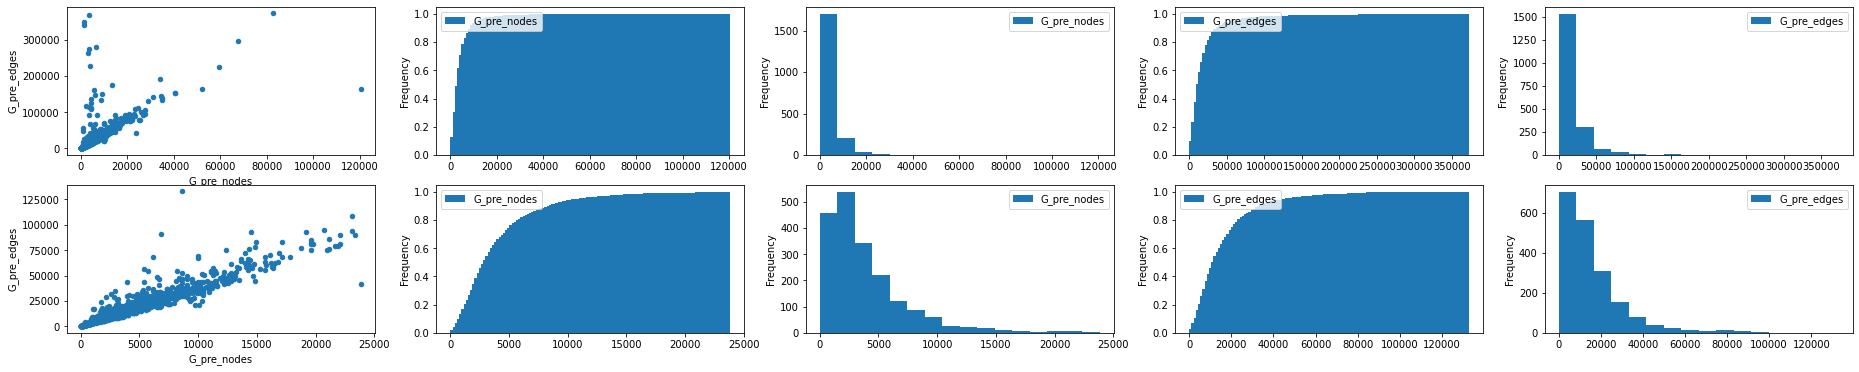

In [6]:
from src.data_loader import get_graph_metadata
import matplotlib.pyplot as plt

# Remove outliers
meta_df_1 = get_graph_metadata(filter_nas=True)
meta_df_2 = get_graph_metadata(filter_nas=True, uq=EXP_CONFIG_UQ, uc=EXP_CONFIG_UC)

print("meta_df_1.shape", meta_df_1.shape)
print("meta_df_2.shape", meta_df_2.shape)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 6))

meta_df_1.plot.scatter(x='G_pre_nodes', y='G_pre_edges', ax=axes[0,0])
meta_df_1[['G_pre_nodes']].plot.hist(cumulative=True, density=1, bins=128, ax=axes[0,1])
meta_df_1[['G_pre_nodes']].plot.hist(ax=axes[0,2], bins=16)
meta_df_1[['G_pre_edges']].plot.hist(cumulative=True, density=1, bins=128, ax=axes[0,3])
meta_df_1[['G_pre_edges']].plot.hist(ax=axes[0,4], bins=16)

meta_df_2.plot.scatter(x='G_pre_nodes', y='G_pre_edges', ax=axes[1,0])
meta_df_2[['G_pre_nodes']].plot.hist(cumulative=True, density=1, bins=128, ax=axes[1,1])
meta_df_2[['G_pre_nodes']].plot.hist(ax=axes[1,2], bins=16)
meta_df_2[['G_pre_edges']].plot.hist(cumulative=True, density=1, bins=128, ax=axes[1,3])
meta_df_2[['G_pre_edges']].plot.hist(ax=axes[1,4], bins=16)

In [7]:
import pandas as pd
from src.data_loader import (get_graph_metadata, create_training_data)

def get_df():
    df_full = create_training_data(_, from_file=True)
    df = df_full.loc[get_graph_metadata(filter_nas=True).index]
    print("df_full.shape", df_full.shape, "df.shape", df.shape)
    return df

# TODO: print no. of features in each dimension
print("auto-generated features", pd.DataFrame(get_df().columns, columns=['feature']).query("feature.str.contains('general_')").shape)
print("expert features", pd.DataFrame(get_df().columns, columns=['feature']).query("feature.str.contains('specific_')").shape)

print("edge types", np.unique(np.array([col.split('num_of_edge_type_')[1] for col in get_df().columns.to_list() if 'num_of_edge_type_' in col])).shape)
print("node types", np.unique(np.array([col.split('node_type_')[1] for col in get_df().columns.to_list() if 'node_type_' in col])).shape)


df_full.shape (1966, 434) df.shape (1966, 434)
auto-generated features (0, 1)
df_full.shape (1966, 434) df.shape (1966, 434)
expert features (0, 1)
df_full.shape (1966, 434) df.shape (1966, 434)
edge types (0,)
df_full.shape (1966, 434) df.shape (1966, 434)
node types (0,)


## Drop Majority-Null and Correlated Columns

df_full.shape (1966, 434) df.shape (1966, 434)


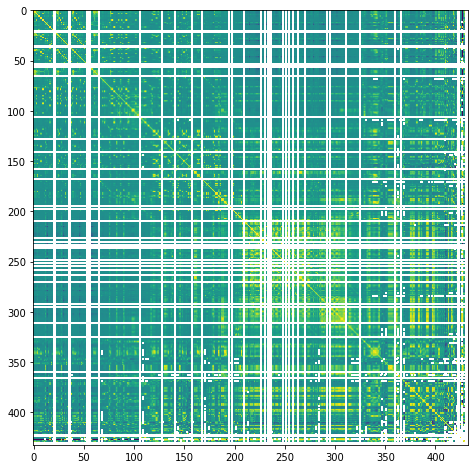

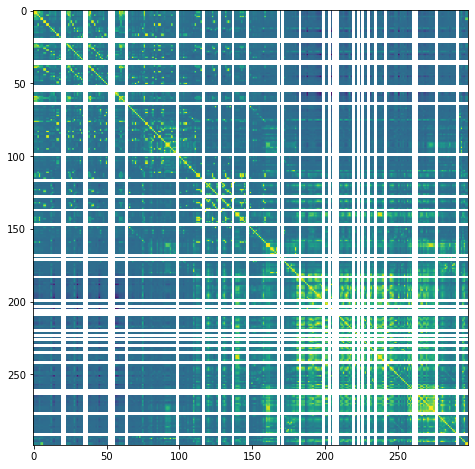

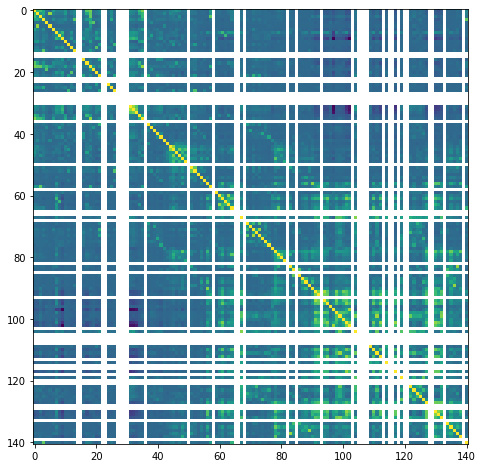

In [8]:
from src.config import LABEL_NAME
from src.transformers import (DropCorrelatedFeatures, DropMajorityNullFeatures)
import matplotlib.pyplot as plt

df = get_df()

X_df = df.loc[:, df.columns != LABEL_NAME]

plt.figure(figsize=(8,8))
plt.imshow(X_df.corr(method='pearson', min_periods=1))
plt.show()

drop_nulls_transformer = DropMajorityNullFeatures(threshold=0.6)
X2_df = drop_nulls_transformer.fit_transform(X_df)

plt.figure(figsize=(8,8))
plt.imshow(X2_df.corr(method='pearson', min_periods=1))
plt.show()

drop_correlates_transformer = DropCorrelatedFeatures(threshold=0.8)
X3_df = drop_correlates_transformer.fit_transform(X2_df)

plt.figure(figsize=(8,8))
plt.imshow(X3_df.corr(method='pearson', min_periods=1))
plt.show()

# Experiments

## Estimate Generalisation Error (ROC/AUC)

In [9]:
from src.config import XGB_DEFAULT_PARAMS
from src.experiments import run_experiment
from src.plots import plot_roc, plot_ap
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(**XGB_DEFAULT_PARAMS)

df = get_df()

grid_params = {
    'drop_nulls__threshold': (0.5, 0.9),
    'drop_correlates__threshold': (0.6, 0.9),
    'model__base_score': (0.45, 0.55),
    'model__colsample_bylevel': (0.8, 1),
    'model__colsample_bynode': (0.8, 1),
    'model__colsample_bytree': (0.8, 1),
    'model__gamma': (0, 5),
    'model__learning_rate': (0.2, 0.4),
    'model__max_delta_step': (0, 5),
    'model__max_depth': (4, 8),
    'model__min_child_weight': (1, 5),
    'model__n_estimators': (80, 120),
    'model__num_parallel_tree': (1, 5),
    'model__reg_alpha': (0, 5),
    'model__reg_lambda': (1, 5),
    'model__scale_pos_weight': (0.8, 1),
    'model__subsample': (0.8, 1),
}

config, results = run_experiment(clf,
                                 grid_params,
                                 df,
                                 n_outer_folds=EXP_CONFIG_OUTER_FOLDS,
                                 n_inner_folds=EXP_CONFIG_INNER_FOLDS,
                                 opt_steps=EXP_CONFIG_HYPER_PARAM_CONFIGS,
                                 save_results=True)

df_full.shape (1966, 434) df.shape (1966, 434)
X.shape (1966, 433) y.shape (1966,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
fold 0 best score 0.891103548935038 best params OrderedDict([('drop_correlates__threshold', 0.8951936311108261), ('drop_nulls__threshold', 0.8086854849254381), ('model__base_score', 0.4643262000653535), ('model__colsample_bylevel', 0.9127208891875246), ('model__colsample_bynode', 0.9033064618304124), ('model__colsample_bytree', 0.8216777551688994), ('model__gamma', 2), ('model__learning_rate', 0.3617821469074908), ('model__max_delta_step', 4), ('model__max_depth', 5), ('model__min_child_weight', 3), ('model__n_estimators', 112), ('model__num_parallel_tree', 5), ('model__reg_alpha', 5), ('model__reg_lambda', 5), ('model__scale_pos_weight', 0.9467092635709078), ('model__subsample', 0.8225231793343013)])
Fitting 3 folds for each of

Fitting 3 folds for each of 2 candidates, totalling 6 fits
fold 9 best score 0.8855481278223781 best params OrderedDict([('drop_correlates__threshold', 0.8259564359143847), ('drop_nulls__threshold', 0.6528358358239243), ('model__base_score', 0.5316336572665561), ('model__colsample_bylevel', 0.9818474482810089), ('model__colsample_bynode', 0.9390575863220936), ('model__colsample_bytree', 0.9949046170555811), ('model__gamma', 4), ('model__learning_rate', 0.25440210094963456), ('model__max_delta_step', 0), ('model__max_depth', 7), ('model__min_child_weight', 1), ('model__n_estimators', 112), ('model__num_parallel_tree', 5), ('model__reg_alpha', 4), ('model__reg_lambda', 3), ('model__scale_pos_weight', 0.9898038057615002), ('model__subsample', 0.860839940940244)])
elapsed_time 5.68 mins


In [10]:
print("CorrelationThreshold", round(np.mean([params['drop_correlates__threshold'] for params in results['best_params_outer_cv']]), 2))
print("NullValueThreshold", round(np.mean([params['drop_nulls__threshold'] for params in results['best_params_outer_cv']]), 2))

CorrelationThreshold 0.86
NullValueThreshold 0.73


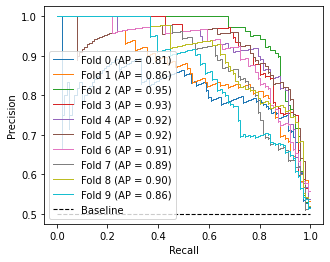

In [11]:
# To interpret volatility and drops in AP for high thresholds
# e.g. see https://github.com/tensorflow/tensorboard/issues/444
from src.plots import plot_ap

plot_ap(results)

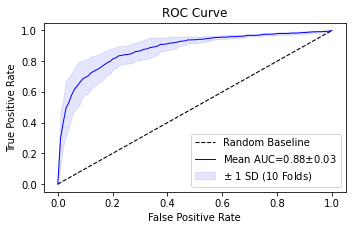

In [12]:
from src.config import (BASE_PATH, TRAINING_DIR)
from src.plots import roc_curve
import os

fig, ax = plt.subplots(1, 1, figsize=(5, 3.3))
plot_roc(ax, results)
plt.tight_layout()
fig.savefig(os.path.join(BASE_PATH, TRAINING_DIR, "roc-curve.pdf"))
plt.show()

## Learning Curve

In [13]:
from src.config import XGB_DEFAULT_PARAMS
from src.experiments import run_sample_complexity
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(**XGB_DEFAULT_PARAMS)

df = get_df()

t_sizes = [0.01, 0.25, 0.5, 0.75, 1]
print("Sample sizes", [size*df.shape[0] for size in t_sizes])
train_sizes, train_scores, test_scores = run_sample_complexity(clf,
                                                               df,
                                                               t_sizes,
                                                               n_folds=EXP_CONFIG_SAMPLE_COMPLEXITY_FOLDS)

df_full.shape (1966, 434) df.shape (1966, 434)
Sample sizes [19.66, 491.5, 983.0, 1474.5, 1966]
t_sizes [0.01, 0.25, 0.5, 0.75, 1]


/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgb

elapsed_time 0.34 mins


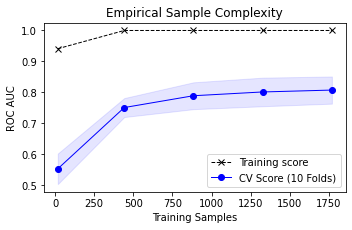

In [14]:
from src.config import (BASE_PATH, TRAINING_DIR)
from src.plots import plot_sample_complexity
import os

fig, ax = plt.subplots(1, 1, figsize=(5, 3.3))
plot_sample_complexity(ax, train_scores, test_scores, train_sizes, EXP_CONFIG_SAMPLE_COMPLEXITY_FOLDS)
plt.tight_layout()
fig.savefig(os.path.join(BASE_PATH, TRAINING_DIR, "sample-complexity.pdf"))
plt.show()

## Feature Importance: Leave one Feature out

In [15]:
from src.config import XGB_DEFAULT_PARAMS
from src.experiments import run_leave_one_feature_out
import pandas as pd
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(**XGB_DEFAULT_PARAMS)

df = get_df()

# Runs 34+min on MBP
baseline_scores, feature_scores = run_leave_one_feature_out(
    clf=clf,
    df=df,
    n_folds=EXP_CONFIG_FEATURE_IMPORTANCE_FOLDS)

auc_baseline_mean = np.mean(baseline_scores)
auc_baseline_sd = np.std(baseline_scores)

mean_auc_loss_df = pd.DataFrame(
    [(k, np.mean(v), np.std(v), auc_baseline_mean - np.mean(v)) for k, v in feature_scores.items()],
    columns=['feature', 'mean_auc', 'std_auc', 'mean_auc_loss']
)

mean_auc_loss_df.to_csv(os.path.join(BASE_PATH, 'feature-imps/mean-auc-loss-5-folds.csv'))
mean_auc_loss_df

df_full.shape (1966, 434) df.shape (1966, 434)


 18%|███████████                                                    | 76/433 [04:51<22:31,  3.78s/it]/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/moritzhaller/Develop/pg-web-compat-modelling/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex

elapsed_time 27.85 mins


,feature,mean_auc,std_auc,mean_auc_loss
0,global_pre_absolute_auto_no_of_edges_of_type_c...,0.870368,0.030588,0.000322
1,global_pre_absolute_auto_no_of_edges_of_type_i...,0.870689,0.028996,0.000000
2,global_pre_absolute_auto_no_of_edges_of_type_s...,0.870689,0.028996,0.000000
3,global_pre_absolute_auto_no_of_edges_of_type_s...,0.872203,0.029210,-0.001514
4,global_pre_absolute_auto_no_of_edges_of_type_r...,0.871167,0.033241,-0.000478
...,...,...,...,...
428,local_delta_absolute_auto_no_of_edges_of_type_...,0.870689,0.028996,0.000000
429,local_delta_absolute_auto_no_of_target_nodes_o...,0.870689,0.028996,0.000000
430,local_delta_absolute_auto_no_of_source_nodes_o...,0.870689,0.028996,0.000000
431,local_pre_absolute_auto_no_of_target_nodes_of_...,0.870689,0.028996,0.000000


<AxesSubplot:>

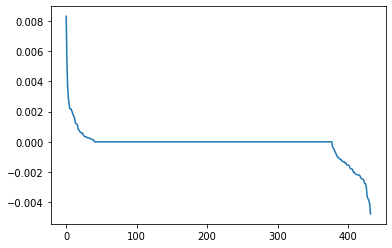

In [16]:
import pandas as pd
auc_df = pd.DataFrame([(k, auc_baseline_mean - np.mean(v), np.std(v)) for k, v in feature_scores.items()], columns=['feature', 'drop_in_mean_auc', 'auc_sd']) \

auc_df \
    .sort_values(by='drop_in_mean_auc', ascending=False).reset_index()['drop_in_mean_auc'].plot()


## Feature Importance: Leave one Feature Group Out

In [21]:
from src.config import XGB_DEFAULT_PARAMS
from src.data_loader import (create_training_data, get_graph_metadata)
from src.experiments import run_leave_one_feature_group_out
from src.plots import plot_drop_in_auc
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(**XGB_DEFAULT_PARAMS)

df = get_df()

dim_1_feature_group_prefixes = ['global', 'local']
dim_2_feature_group_prefixes = ['pre', 'delta']
dim_3_feature_group_prefixes = ['auto', 'expert']
dim_4_feature_group_prefixes = ['absolute', 'relative']

baseline_scores, dim_1_feature_group_scores = run_leave_one_feature_group_out(
    clf, df, dim_1_feature_group_prefixes, n_folds=EXP_CONFIG_FEATURE_IMPORTANCE_FOLDS)

_, dim_2_feature_group_scores = run_leave_one_feature_group_out(
    clf, df, dim_2_feature_group_prefixes, n_folds=EXP_CONFIG_FEATURE_IMPORTANCE_FOLDS)

_, dim_3_feature_group_scores = run_leave_one_feature_group_out(
    clf, df, dim_3_feature_group_prefixes, n_folds=EXP_CONFIG_FEATURE_IMPORTANCE_FOLDS)

_, dim_4_feature_group_scores = run_leave_one_feature_group_out(
    clf, df, dim_4_feature_group_prefixes, n_folds=EXP_CONFIG_FEATURE_IMPORTANCE_FOLDS)

df_full.shape (1966, 434) df.shape (1966, 434)
elapsed_time 0.13 mins
elapsed_time 0.16 mins
elapsed_time 0.16 mins
elapsed_time 0.13 mins


['Page' 'Intervention']
[-0.01  -0.004]
['Auto' 'Expert']
[-0.037 -0.004]
['Absolute' 'Relative']
[-0.024 -0.009]


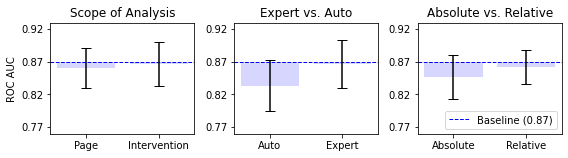

In [128]:
from src.config import (BASE_PATH, TRAINING_DIR)
from src.plots import (plot_drop_in_auc)
import os

dim_2_labels = ['Intervention', 'Page']
dim_3_labels = ['Auto', 'Expert']
dim_4_labels = ['Absolute', 'Relative']

fig, ax = plt.subplots(1, 3, figsize=(8, 2.3))
y_lim=(0.76, 0.93)
baseline_mean = np.mean(baseline_scores)

ax[0].set_ylim([y_lim[0]-baseline_mean, y_lim[1]-baseline_mean])
plot_drop_in_auc(ax[0],
                 baseline_scores,
                 dim_2_feature_group_scores,
                 labels=dim_2_labels, sorted=True)

ax[1].set_ylim([y_lim[0]-baseline_mean, y_lim[1]-baseline_mean])
plot_drop_in_auc(ax[1],
                 baseline_scores,
                 dim_3_feature_group_scores,
                 labels=dim_3_labels, sorted=True)

ax[2].set_ylim([y_lim[0]-baseline_mean, y_lim[1]-baseline_mean])
plot_drop_in_auc(ax[2],
                 baseline_scores,
                 dim_4_feature_group_scores,
                 labels=dim_4_labels, sorted=True)

ax[0].set_ylabel("ROC AUC")

ax[0].title.set_text('Scope of Analysis')
ax[1].title.set_text('Expert vs. Auto')
ax[2].title.set_text('Absolute vs. Relative')

ax[2].legend(loc='lower right')

plt.tight_layout()
fig.savefig(os.path.join(BASE_PATH, TRAINING_DIR, "feature-group-imp.pdf"))
plt.show()

